### Fire Weather Prep
_Updated Jan 2016_ <p>
The goal of this notebook is to leverage RAWS data to generate fire weather inputs for LANDIS across the landscape. The notebook imports from FireWeatherIndex_Calculations.py, a script originially written by Louise Loudermilk to convert time series of daily data into the LANDIS input files required by the Dynamic Fire and Fuels System extension. Here, we modify this script and set up a work flow to process RAWS data by year.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime, math
from scipy import stats
from FireWeatherIndex_Calculations import DynamicFireWeatherCalculations
DFFSDir = 'C:/Research/Dinkey_Creek/DFFS_Data/FireWeather/'

#### I chose to represent 
fire weather using RAWS data from each of the three fire regions represented in our simulation. The fire regions were defiend by Shuang et al., 2015, and were defined using elevation bins. FR1 is the lowest elevation region, and RAWS data from Batterson California were used to generate the fire weather (elvation = 963 m). FR2 is the middle elevation region, with fireweather derived from the Dinkey California station (elevation = 1727 m). FR3 is the high elevation region, and I chose the High Sierra California RAWS station (elevation = 2256 m). All stations are fairly proximal to one another, and roughly represent the middle elevation of their respective fire regions.

RAWS data fills bad values with a mask (I chose -9999). That means we need to remove those rows before the fireweather prep script can operate on the downloaded data.

The DFFS in LANDIS-II treats wind direction as the direction the wind is blowing _to_, and consequently we need to modify wind direction by 180 degrees in order to convert the RAWS data, as most climatological stations report the wind direction as the direction that the wind is blowing _from_.

The current state of Louise's script needs some specific data formatting.. since some of the RAWS data starts or ends in the middle of  a year, I clipped the inputs to start in 2002 and end in 2014.. that way only complete years (mostly just that the data start on the 1st and end on the 365th day of year) are used in the analysis -- I Think this is only a problem because of the way the script assesses season, and think it might be worth modernizing the script to leverage Pandas and timestamps...

In [39]:
# Quick function to flip the wind direction from RAWS to account for the difference in how directions are
# handled between RAWS and the DFFS.

def adjustWindAz(windDir):
    if math.degrees(math.radians(windDir) + math.radians(180)) > 360:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180)) - 360
    else:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180))
    return windDir_adj
        
# Function to clean up the mask values and data types from the RAWS outputs. Note, here the RAWS ASCII Downloads
# have to be manually edited to conform to the sample input from Louise's script in order to run.

def cleanRaws(formattedRawsData, maskValue, yearStart, yearStop, cleanedRawsData):
    rawsdata = pd.read_csv(formattedRawsData)
    rawsdata[rawsdata == maskValue] = np.nan
    rawsdata = rawsdata.dropna()
    rawsdata.Juliandate = rawsdata.Juliandate.astype(int)
    print 'Converting wind directions.....'
    rawsdata.windazimuth = rawsdata.windazimuth.apply(adjustWindAz) # wind direction adjustment
    rawsdata.windazimuth = rawsdata.windazimuth.astype(int)
    rawsdata.relativehumidity = rawsdata.relativehumidity.astype(int)
    rawsdata = rawsdata[rawsdata.year > yearStart]
    rawsdata = rawsdata[rawsdata.year < yearStop]
    rawsdata.windspeed = rawsdata.windspeed * 3.6 # Convert m/s to km/h

    rawsdata.to_csv(cleanedRawsData, index = False)
    


### Fire weather generation
I'm going to step through the fire weather generation for two main branches of the simulations at Dinkey: historic and severe fire weather. The overall premise here is that historic fire weather be derived from RAWS data over the past ~10-15 years, and gathered from RAWS stations that 1) are proximal to the fire regions being simulation at Dinkey, and 2) roughly represent the climate distribution ranges we see across the Dinkey landscape. The severe fire weather will be generated from a subset of the historic weather, which was associated with large fires (specifically the Rim and Rough fires).
#### Historic fire weather
Generation of the fire weather used in the historic (non-severe) Dinkey Creek runs. More information is available in the Dinkey Creek notebook, specifically related to the result of the fire weather on the runs, etc.

In [40]:
# Clean up RAWS raw data and generate FW inputs for the three fire regions

cleanRaws(DFFSDir + 'BATTERSON_RAWS_FORMATTED.csv',-9999, 
          2000, 2014, DFFSDir + 'FR1_RawsWeather.csv')
cleanRaws(DFFSDir + 'DINKEY_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR2_RawsWeather.csv')
cleanRaws(DFFSDir + 'HIGH_SIERRA_RAWS_FORMATTED.csv',-9999,  
          2000, 2014, DFFSDir + 'FR3_RawsWeather.csv')


# Run Louise's script on the three fire regions input RAWS generated previously.
fireRegions = ['FR1','FR2','FR3']
for region in fireRegions:
    p = DynamicFireWeatherCalculations(DFFSDir + region +'_RawsWeather.csv',
                                       DFFSDir + 'sample_startingvalues_' + region + '.csv',
                                       DFFSDir +  region +'_FireWeather.csv', region)
    p.run()
FR1 = pd.read_csv(DFFSDir + 'FR1_FireWeather.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_FireWeather.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_FireWeather.csv')

DinkeyFW = pd.concat([FR1, FR2, FR3])
DinkeyFW.to_csv(DFFSDir + 'DinkeyFW.csv', index = False)
DinkeyFW.groupby(['Ecoregion','Season']).count()


Converting wind directions.....
Converting wind directions.....
Converting wind directions.....
No. days being evaluated  4644

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  2237
No. days being evaluated  4725

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  1576
No. days being evaluated  4356

Writing output file for LANDIS-II  . . . 

 no. of daily values (rows) output to file =  2391


FFMC   BUI   WSV  WINDDir  FWIBin
Ecoregion Season                                   
FR1       fall     190   190   190      190     190
          spring    73    73    73       73      73
          summer  1974  1974  1974     1974    1974
FR2       fall      26    26    26       26      26
          spring     1     1     1        1       1
          summer  1549  1549  1549     1549    1549
FR3       fall     238   238   238      238     238
          spring    79    79    79       79      79
          summer  2074  2074  2074     2074    2074

#### We need to hack 
the weather data a bit to allow fires in Spring for both FR2 and FR3. Realistically, we don't expect these regions to burn in the spring, however LANDIS throws errors if we want to say some regions can burn in the spring and some can't. Our solution here is to create some fake fire weather data for FR2 and FR3 with sufficiently high foliar moisture to effectively keep fires from (at least) propagating in the Spring. 

Depending on adjustments to the fire weather data, this step might not be necessary -- however, we're adding 10 draws to an enormous number of fire weather entries, so the impact is negligible. 

In [41]:
FFMC = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
BUI = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
WSV = [0,0,0,0,0,0,0,0,0,0]
WDR = [0,0,0,0,0,0,0,0,0,0]
FWIBin = [1,1,1,1,1,1,1,1,1,1]
Season = ['spring','spring','spring','spring','spring',
          'spring','spring','spring','spring','spring']
Ecoregion = ['FR2','FR2','FR2','FR2','FR2',
             'FR3','FR3','FR3','FR3','FR3']
FW_to_Add = pd.DataFrame(dict(FFMC = FFMC, BUI = BUI, WSV = WSV, 
                              WINDDir = WDR, FWIBin = FWIBin, 
                              Season = Season, Ecoregion = Ecoregion))

DinkeyFW_h = pd.concat((DinkeyFW, FW_to_Add))
DinkeyFW_h.to_csv(DFFSDir + 'DinkeyFW_h.csv', index = False)

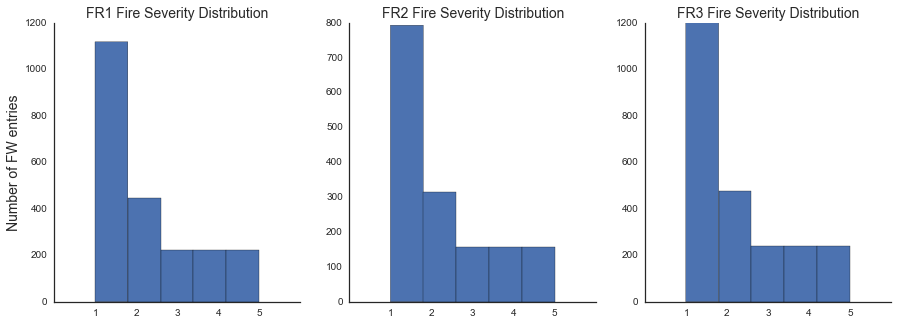

In [43]:
f, ax = plt.subplots(1,3, figsize =(15,5))
idx = 0
axs = f.axes
for Eco in np.unique(DinkeyFW_h.Ecoregion):
    ax = axs[idx]
    toPlot = DinkeyFW_h[DinkeyFW_h.Ecoregion == Eco]
    toPlot.FWIBin.hist(ax = ax, bins = 5)
    ax.set_title(Eco + ' Fire Severity Distribution', fontsize = 14)
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['','1','2','3','4','5',''])
    #ax.set_ylim([0,1100])
    ax.grid('off')
    if idx == 0:
        ax.set_ylabel('Number of FW entries', fontsize = 14)
    
    idx = idx + 1
sns.set_style('white')
sns.despine()

#### Severe Fire weather
Our first cut was to take data from the Rim fire and the Rough fire, and drive the fire weather based on those time series. The Rim fire data I grabbed from Smith Peak -- chose to include the entire year, given the whole period was fairly dry, and obviously resulted in a large amount of dry fuel. The Rough fire data we had to grab from a portable station (SNF01), by contacting the Sierra parks people. The format of the Rough fire data is pretty old school, lots of conversions to take care of in a one-off fashion before we can work them into FW format.

In [86]:
# Handle the SNF01 data
SNF01 = pd.read_csv(DFFSDir + 'SNF01_Portable-2016-1-19-13-46-28_formatted.csv')
SNF01['Date'] = pd.to_datetime(SNF01.DateTime)
SNF01.index = SNF01.Date
SNF01_ATC = (SNF01.ATF - 32) * 5.0/9.0 # Convert deg F to deg C
SNF01_WS_mps = SNF01.WSM * 0.44704 # Convert miles/h to meters/s
SNF01_P_mm = SNF01.RNIN * 25.4
RoughFW = pd.DataFrame(dict(year = SNF01.index.year, Juliandate = SNF01.index.dayofyear,
                           temp = SNF01_ATC, windspeed = SNF01_WS_mps, windazimuth = SNF01.WDD,
                           relativehumidity = SNF01.RHP, precip_mm = SNF01_P_mm))
RoughFW.to_csv(DFFSDir + 'SNF01_Portable_FORMATTED.csv', index = False)
cleanRaws(DFFSDir + 'SNF01_Portable_FORMATTED.csv',-9999, 
          2000, 2016, DFFSDir + 'SNF01_RawsWeatherS.csv')


Converting wind directions.....


In [89]:

# Clean up RAWS raw data and generate FW inputs for the three fire regions -- This is just
# the same data for each fire region, saved under three different file names.

cleanRaws(DFFSDir + 'SMITHPEAK_SNF01_RAWS_FORMATTED.csv',-9999, 
          2000, 2016, DFFSDir + 'FR1_RawsWeatherS.csv')
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999,  
          2000, 2016, DFFSDir + 'FR2_RawsWeatherS.csv')
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999,  
          2000, 2016, DFFSDir + 'FR3_RawsWeatherS.csv')

# Run Louise's script on the three fire regions input RAWS data.
fireRegions = ['FR1','FR2','FR3']
for region in fireRegions:
    p = DynamicFireWeatherCalculations(DFFSDir + region +'_RawsWeatherS.csv',
                                       DFFSDir + 'sample_startingvalues_' + region + '.csv',
                                       DFFSDir +  region +'_FireWeatherS.csv', region)
    p.run()
FR1 = pd.read_csv(DFFSDir + 'FR1_FireWeatherS.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_FireWeatherS.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_FireWeatherS.csv')

DinkeyFW = pd.concat([FR1, FR2, FR3])
DinkeyFW.to_csv(DFFSDir + 'DinkeySevereFW.csv', index = False)
DinkeyFW.groupby(['Ecoregion','Season']).count()


Converting wind directions.....
Converting wind directions.....
Converting wind directions.....
No. days being evaluated  1152



TypeError: unsupported operand type(s) for -: 'float' and 'str'

### Finally a Win
Fire weather generated from the Rim fire (using 2013 data from Smith Peak RAWS) created a much more aggressive fire severity profile across Dinkey Creek. To flesh out the fire weather options more, I need to add in some RAWS data from the Rough fire from the Sierras in 2015. This is proving difficult, the stations I would want to use were portable, and placed in / near the fire footprint in July following the ignition. Park Ridge and Pinehurst RAWS stations currently have their own issues as well. Pinehurst only has data for the fisrt half of 2015, and Park Ridge weather shows low wind speeds, and no significant difference in mean air T relative to the Dinkey RAWS for example. 

### Alternate approach
Given that we only have one year of fire weather draws, and that LANDIS-II moved away from the mean and variance approach to dynamically build distributions, I'm going to use 2013 data from the Rim fire to generate a distribution and tack on 2 more years of weather data that have similar met values. The intent here is to increase the fire weather draws for finer granularity in severity map generation and simply to reduce the redundancy of fire weather draws. 

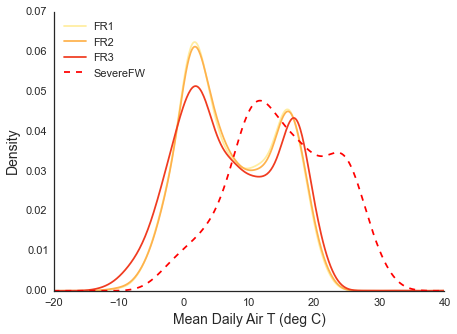

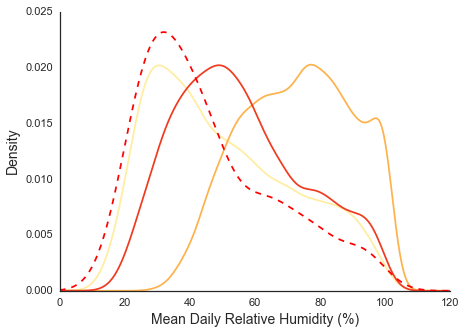

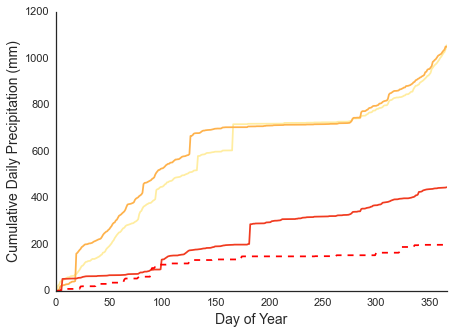

In [275]:
# Start by importing the Smith Peak RAWS data -- our best best for the Rim fire weather
# Clean it up and save the resulting inputs to the fire weather prep -- then 
# read it into a dataframe for visualization and mucking with.
cleanRaws(DFFSDir + 'SMITHPEAK_RAWS_FORMATTED.csv',-9999, 
          2000, 2014, DFFSDir + 'Severe_RawsWeather.csv')
severeFW = pd.read_csv(DFFSDir + 'Severe_RawsWeather.csv')
severeFW['FR'] = 'All' # Note here, I'm using the same fire weather for all fire regions ...

# Lets also read in FW for the three other regions so we can create distributions of 
# historic and 'severe' FW -- a figure that will probably be needed to show in the
# MS that results from this analysis.
FR1_historic = pd.read_csv(DFFSDir + 'FR1_RawsWeather.csv')
FR2_historic = pd.read_csv(DFFSDir + 'FR2_RawsWeather.csv')
FR3_historic = pd.read_csv(DFFSDir + 'FR3_RawsWeather.csv')
FR1_historic['FR'] = 'FR1'
FR2_historic['FR'] = 'FR2'
FR3_historic['FR'] = 'FR3'

historicFW = pd.concat([FR1_historic, FR2_historic, FR3_historic])

# fireregion colors
FireregionFC = ['#ffeda0', '#feb24c', '#f03b20']

# Start by displaying distributions for the params of interest
FWParams = ['temp','windspeed','relativehumidity','precip_mm']

f, ax = plt.subplots(1,1, figsize =(7,5))
coloridx = 0
#sns.set_context("notebook", font_scale=1.1)
for FR in fireRegions:
    toPlot = historicFW[historicFW.FR == FR]
    toPlot.temp.plot(ax = ax, kind = 'kde', color = FireregionFC[coloridx])
    coloridx = coloridx + 1
severeFW.temp.plot(ax = ax, kind = 'kde', ls = '--', color = 'red')
ax.set_xlim([-20, 40])
ax.set_xlabel('Mean Daily Air T (deg C)', fontsize = 14)
ax.set_ylabel('Density', fontsize = 14)
ax.legend(['FR1','FR2','FR3','SevereFW'], loc = 'upper left')
sns.despine()

f, ax = plt.subplots(1,1, figsize =(7,5))
coloridx = 0
#sns.set_context("notebook", font_scale=1.1)
for FR in fireRegions:
    toPlot = historicFW[historicFW.FR == FR]
    toPlot.relativehumidity.plot(ax = ax, kind = 'kde', color = FireregionFC[coloridx])
    coloridx = coloridx + 1
severeFW.relativehumidity.plot(ax = ax, kind = 'kde', ls = '--', color = 'red')
ax.set_xlim([0, 120])
ax.set_xlabel('Mean Daily Relative Humidity (%)', fontsize = 14)
ax.set_ylabel('Density', fontsize = 14)
sns.despine()

f, ax = plt.subplots(1,1, figsize =(7,5))
coloridx = 0
#sns.set_context("notebook", font_scale=1.1)
for FR in fireRegions:
    toPlot = historicFW[historicFW.FR == FR]
    # this mess just uses pandas groupby to generate a mean daily precip for all 14 years of RAWS
    # data for a given fire region, and accumulates those mean values over time.
    toPlot.groupby('Juliandate').precip_mm.mean().cumsum().plot(ax = ax, color = FireregionFC[coloridx])
    coloridx = coloridx + 1
severeFW.precip_mm.cumsum().plot(ax = ax, ls = '--', color = 'red')
ax.set_xlabel('Day of Year', fontsize = 14)
ax.set_ylabel('Cumulative Daily Precipitation (mm)', fontsize = 14)
sns.despine()




### Creating synthetic observations of severe fire based on Rim fire RAWS Data
Looks like fitting 2 gaussian curves to the distribution of temperatures on record during the Rim fire
is going to be the best way to generate more data that fits in nicely with the existing distribution. There
are other options here for sure, but trying to keep this as simple as possible I think has a lot of benefit

array([  4.17889104e-02,   1.23081322e+01,   5.43483031e+00,
         2.49928765e-02,   2.40253906e+01,   3.58678061e+00,
         5.55333190e-03])

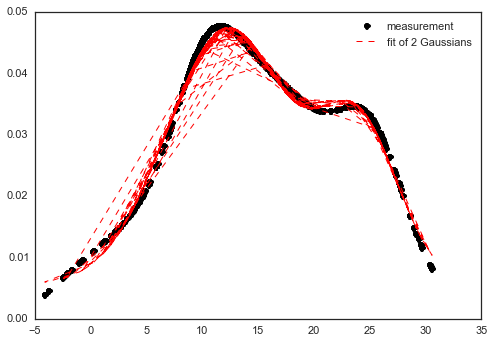

In [449]:
from scipy import optimize

kernel = stats.gaussian_kde(severeFW.temp)

yy = kernel(severeFW.temp)
xx = severeFW.temp
plt.plot(xx,yy, 'ok')
data = pd.DataFrame(dict(temps = xx, density = yy))

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + offset)

def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return three_gaussians(x, h1, c1, w1, h2, c2, w2, 0,0,1, offset)

errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2
guess2 = [0.05, 10, 5, 0.04, 27, 5, 0]  # I removed the peak I'm not too sure about
optim2, success = optimize.leastsq(errfunc2, guess2[:], args=(data.temps, data.density))

plt.plot(data.temps, data.density, 'ok', label='measurement')
plt.plot(data.temps, two_gaussians(data.temps, *optim2),
    lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.legend(loc='best')

#plt.plot(data.temps, two_gaussians(data.temps, *optim2), 'or')
optim2